- одну тему могут выбрать до 2ух студентов (каждый делает на своем наборе данных)
- Сроки с 16 апреля по 7 мая включительно (3 недели)
- Сдача онлайн 7 ого мая (резервный день 14 мая - кто не успеет 7ого рассказать)
- Формат сдачи: устный в виде .tex презентации (содержание презентации по ссылке с темами)
- Код можно делать без выводов(только выделить основные блоки, т.к. выводы будут в презентации)
- Перед сдачей прогоните ноутбук от начала до конца и сохраните выводы
- Код и презентацию присылать

1) мне в личку
2) с сообщением «МФТИ, лабораторная работа 2, имя фамилия»
3) файл .ipynb с именем "name_surname_lw2.ipynb"
4) файл .pdf с именем "name_surname_lw2.pdf"

# Lab 202 PCA on higher orders.
1. Construct a linear map of pairwise distance matrix to a space of lower dimensionality and plot the data.
2. There are two possibilities: high-rank dimensional reduction and order reduction.
3. If you could demonstrate the order reduction, it would be great.
4. The pictures are appreciated.

* Code [Tucker, Tensor-train, and variants]
* Data sets [Cartoon, Sound, fMRI, and variants]

In [ ]:
!pip install nilearn
!pip install tensorly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 3.5 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
import numpy as np
import nibabel as nib
import os
import pandas as pd
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_haxby
from tensorly.decomposition import TensorTrain , tucker
from scipy.linalg import orthogonal_procrustes
import tensorly as tl
from sklearn.manifold import MDS
from tensorly.decomposition import parafac
import tensorly as tl
from tensorly.decomposition import partial_tucker


In [ ]:
pip install hottbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 2.1 MB/s eta 0:00:00


In [ ]:
from hottbox.core import Tensor
from hottbox.algorithms.decomposition import TTSVD, HOSVD, HOOI, CPD
from hottbox.metrics import residual_rel_error
from tqdm import tqdm

In [ ]:
class haxby_dataset():
    def __init__(self):
        path = '\data_fmri'
        self.data_files = fetch_haxby(data_dir=path, subjects=(1, 2, 3, 4, 5, 6), fetch_stimuli=True, url=None, resume=True, verbose=1)
    def get_sub_data(self, num):
        fmri_data = self.data_files['func'][num-1]
        fmri_img = nib.load(fmri_data)
        fmri_array = fmri_img.get_fdata()
        return fmri_array

def plot_data( fmri, slice , save= False, filename='fmri' , figsize = (10,3)):
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    slices = [fmri[slice[0],:,:].T , fmri[:,slice[1],:].T, fmri[:,:,slice[2]].T]
    for i, data in enumerate(slices) :
        axes[i].imshow(data, cmap="hot", origin="lower" , aspect='auto')
        axes[i].set_title(f"Slice {i}, pos {slice[i]}", fontsize=8)
    for ax in axes:
        ax.axis('off')
    plt.suptitle('FMRI Brain Slices', fontsize=10)
    if save:
        file_name = f'./img/{filename}.pdf'
        os.makedirs(os.path.dirname(file_name), exist_ok=True)
        plt.savefig(file_name, dpi=300)
    plt.show()

def plot_data_array( data_array , slice ) :
    for data in data_array :
        plot_data(data , slice )


## FMRI
* В качестве датасета возьмем FMRI снимок

In [ ]:
dataset = haxby_dataset()
datafiles = dataset.data_files


Added README.md to \data_fmri


Dataset created in \data_fmri/haxby2001



 ...done. (1 seconds, 0 min)
 ...done. (0 seconds, 0 min)


Downloaded 313073664 of 314803244 bytes (99.5%,    0.0s remaining) ...done. (6 seconds, 0 min)
Extracting data from \data_fmri/haxby2001/06208d797af1660c9df6324471f48b88/subj1-2010.01.14.tar.gz..... done.


Downloaded 280420352 of 291168628 bytes (96.3%,    0.2s remaining) ...done. (4 seconds, 0 min)
Extracting data from \data_fmri/haxby2001/06208d797af1660c9df6324471f48b88/subj2-2010.01.14.tar.gz..... done.


Downloaded 238141440 of 296936090 bytes (80.2%,    1.0s remaining) ...done. (5 seconds, 0 min)
Extracting data from \data_fmri/haxby2001/06208d797af1660c9df6324471f48b88/subj3-2010.01.14.tar.gz..... done.


Downloaded 311123968 of 329954386 bytes (94.3%,    0.2s remaining) ...done. (4 seconds, 0 min)
Extracting data from \data_fmri/haxby2001/06208d797af1660c9df6324471f48b88/subj4-2010.01.14.tar.gz..... done.


Downloaded 311754752 of 322730263 bytes (96.6%,    0.1s remaining) ...done. (4 seconds, 0 min)
Extracting data from \data_fmri/haxby2001/06208d797af1660c9df6324471f48b88/subj5-2010.01.14.tar.gz..... done.


Downloaded 316776448 of 322839597 bytes (98.1%,    0.1s remaining) ...done. (4 seconds, 0 min)
Extracting data from \data_fmri/haxby2001/06208d797af1660c9df6324471f48b88/subj6-2010.01.14.tar.gz..... done.


 ...done. (0 seconds, 0 min)
Extracting data from \data_fmri/haxby2001/5cd78c74b711572c7f41a5bddb69abca/stimuli-2010.01.14.tar.gz..... done.


In [ ]:
fmris = dataset.get_sub_data(1)
fmris = fmris.transpose((3, 0, 1, 2))
fmris.shape

(1452, 40, 64, 64)

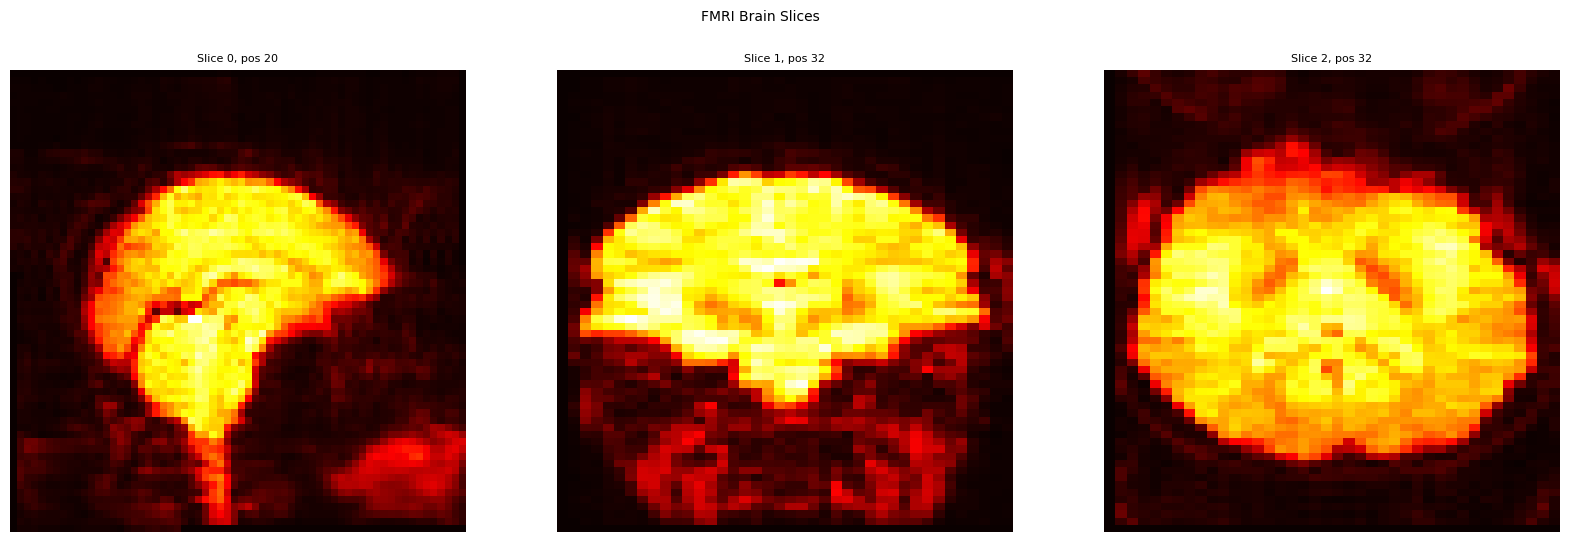

In [ ]:
plot_data(fmris[10], (20, 32, 32), figsize = (20,6))

In [ ]:
data = fmris[10]

In [ ]:
def decompose( tensor, components_range , decompose_function ) :
    error_array = []
    decompose_tensor_array = []
    for n_components in tqdm(components_range) :
        decomposed_tensor = decompose_function(tensor , n_components )
        error = np.linalg.norm( tensor - decomposed_tensor ) / np.linalg.norm(tensor)
        error_array.append(error)
        decompose_tensor_array.append(decomposed_tensor)
    return error_array , decompose_tensor_array

def tucker_decompose(tensor , n_components ) :
    core, factors = tl.decomposition.tucker(tensor, rank=[n_components,n_components,n_components])
    decomposed_tensor = tl.tucker_tensor.tucker_to_tensor((core, factors))
    return decomposed_tensor

def PLS_decompose(tensor , n_components ) :
    tensor_array = tl.tensor(tensor)
    factors = parafac(tensor_array, rank = n_components)
    factors0 = factors[0]
    factor1 = factors.factors[0]
    factor2 = factors.factors[1]
    factor3 = factors.factors[2]
    factors0.shape , factor1.shape , factor2.shape , factor3.shape
    reconstructed_tensor = np.einsum('im,jm,km->ijk ' , factor1 , factor2 , factor3)
    return reconstructed_tensor

def HOSVD_decompose(tensor ,n_components) :
    hosvd = HOSVD()
    ranks = (n_components,n_components,n_components)
    tensor = Tensor(tensor)
    tensor_tucker = hosvd.decompose(tensor, ranks)
    tensor_new = tensor_tucker.reconstruct()
    return tensor_new.data

def HOOI_decompose(tensor , n_components) :
  hooi = HOOI()
  ranks = (n_components,n_components,n_components)
  tensor = Tensor(tensor)
  tensor_tucker = hooi.decompose(tensor, ranks)
  tensor_new = tensor_tucker.reconstruct()
  return tensor_new.data

def TTSVD_decompose(tensor , n_components) :
  hooi = TTSVD()
  ranks = (n_components,n_components)
  tensor = Tensor(tensor)
  tensor_tucker = hooi.decompose(tensor, ranks)
  tensor_new = tensor_tucker.reconstruct()
  return tensor_new.data


In [ ]:
components_range = range(1,40)

## Tucker

In [ ]:
error_array_tucker , decomposed_tensors_tucker = decompose(data , components_range , tucker_decompose )

100%|██████████| 39/39 [00:05<00:00,  7.17it/s]


## PLS

In [ ]:
error_array_PLS , decomposed_tensors_PLS = decompose(data , components_range , PLS_decompose )

100%|██████████| 39/39 [03:08<00:00,  4.84s/it]


## HOSVD

In [ ]:
error_array_HOSVD , decomposed_tensors_HOSVD = decompose(data , components_range , HOSVD_decompose )

100%|██████████| 39/39 [00:00<00:00, 47.02it/s]


## HOOI

In [ ]:
error_array_HOOI , decomposed_tensors_HOOI = decompose(data , components_range , HOOI_decompose )

100%|██████████| 39/39 [00:03<00:00, 12.23it/s]


## TTSVD

In [ ]:
error_array_TTSVD , decomposed_tensors_TTSVD = decompose(data , components_range , TTSVD_decompose )

100%|██████████| 39/39 [01:03<00:00,  1.62s/it]


In [ ]:
tensor_array = tl.tensor(data)
factors = parafac(tensor_array, rank = 5)
factors0 = factors[0]
factor1 = factors.factors[0]
factor2 = factors.factors[1]
factor3 = factors.factors[2]

In [ ]:
factor1.shape , factor2.shape , factor3.shape

((40, 5), (64, 5), (64, 5))

## Сравним ошибку методов в зависимости от числа компонент

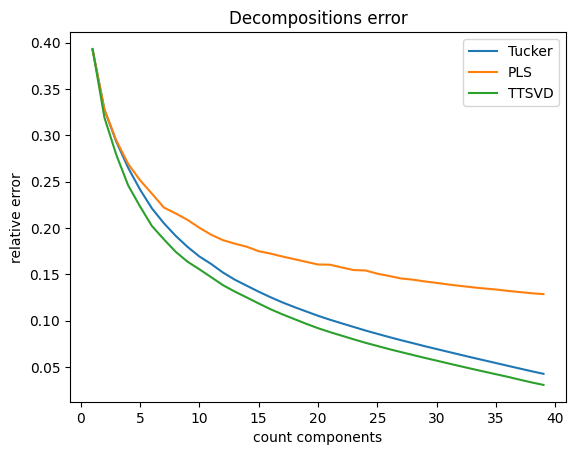

In [ ]:
plt.plot(components_range , error_array_tucker , label = 'Tucker')
plt.plot(components_range , error_array_PLS , label = 'PLS')
# plt.plot(components_range , error_array_HOSVD , label = 'HOSVD')
# plt.plot(components_range , error_array_HOOI , label = 'HOOI')
plt.plot(components_range , error_array_TTSVD , label = 'TTSVD')
plt.legend()
plt.ylabel('relative error')
plt.xlabel('count components')
plt.title('Decompositions error')
plt.show()

## Наглядно результаты методов

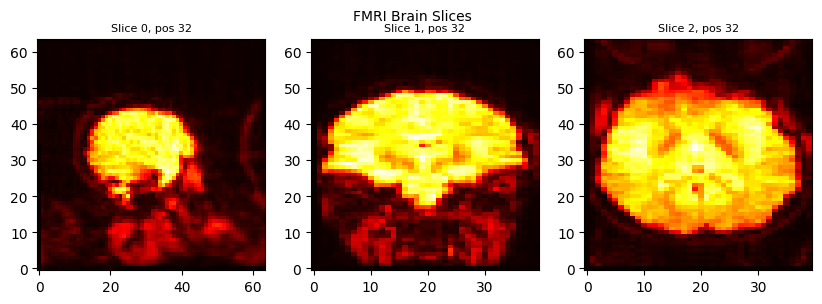

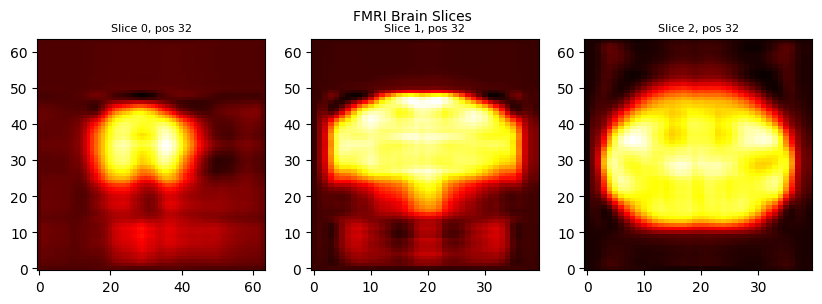

In [ ]:
plot_data_array([data] + decomposed_tensors_tucker[4:5] , (32,32,32))

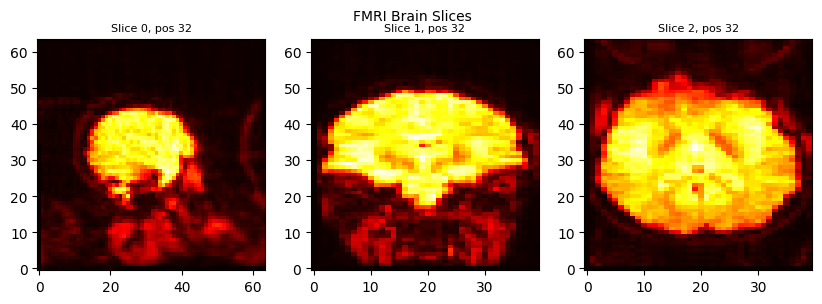

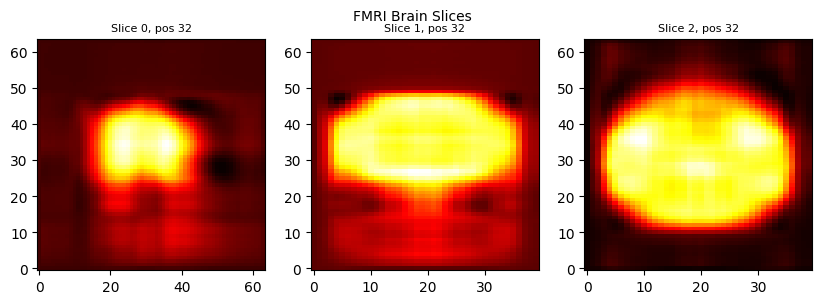

In [ ]:
plot_data_array([data] + decomposed_tensors_PLS[4:5] , (32,32,32))

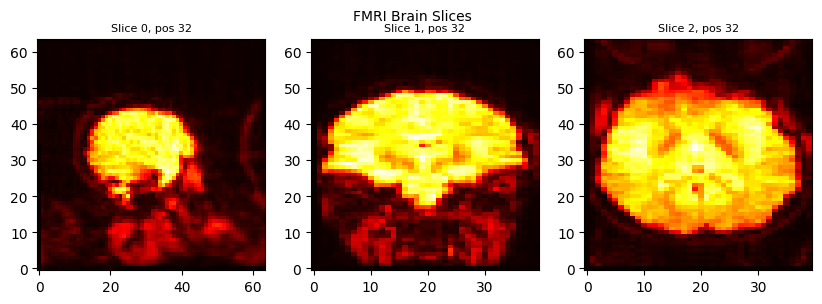

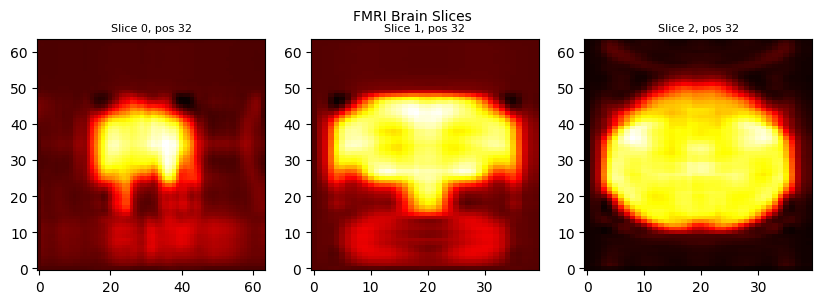

In [ ]:
plot_data_array([data] + decomposed_tensors_TTSVD[4:5] , (32,32,32))

##  Оригинальное видео

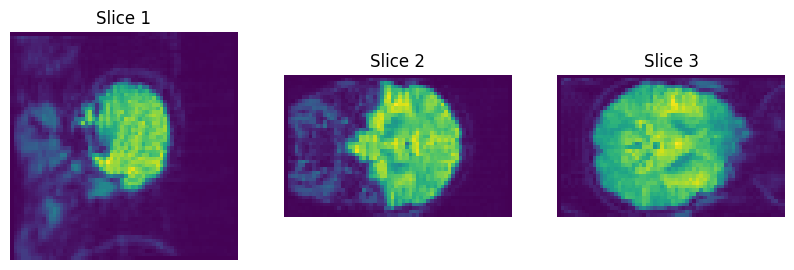

100%|██████████| 30/30 [00:09<00:00,  3.02it/s]


In [ ]:
from IPython.display import clear_output

try:
    for i in tqdm(range(30)):
        clear_output(True, )
        fig, axes = plt.subplots(1, 3, figsize=(10, 3))
        axes[0].imshow(fmris[i][32,:,:])
        axes[0].set_title('Slice 1')
        axes[1].imshow(fmris[i][:,32,:])
        axes[1].set_title('Slice 2')
        axes[2].imshow(fmris[i][:,:,32])
        axes[2].set_title('Slice 3')
        for ax in axes:
            ax.axis('off')
        plt.show()
except:
    pass

## Tucker decomposed видео

In [ ]:
tucker_decomposed = [tucker_decompose(fmris[i] , n_components= 25) for i in tqdm(range(fmris.shape[0]))]

100%|██████████| 1452/1452 [04:43<00:00,  5.12it/s]


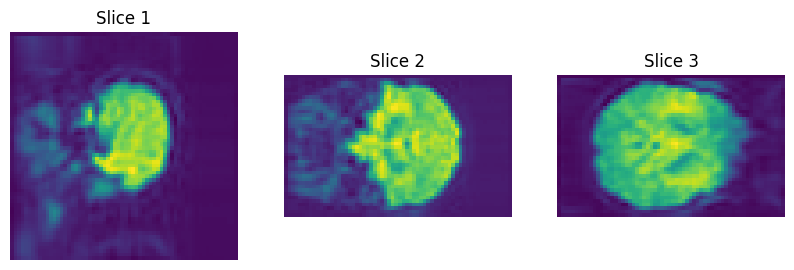

100%|██████████| 30/30 [00:09<00:00,  3.32it/s]


In [ ]:
from IPython.display import clear_output

try:
    for i in tqdm(range(30)):
        clear_output(True, )
        fig, axes = plt.subplots(1, 3, figsize=(10, 3))
        axes[0].imshow(tucker_decomposed[i][32,:,:])
        axes[0].set_title('Slice 1')
        axes[1].imshow(tucker_decomposed[i][:,32,:])
        axes[1].set_title('Slice 2')
        axes[2].imshow(tucker_decomposed[i][:,:,32])
        axes[2].set_title('Slice 3')
        for ax in axes:
            ax.axis('off')
        plt.show()
except:
    pass

# MDS - Multi dimentional scaling

* Это способ визуализации информации содержащейся в матрице расстояний.

In [ ]:
def distances( data ) :
    distances = np.zeros((len(data), len(data)))
    for i in tqdm(range(len(data))):
        for j in range(i+1, len(data)):
            distances[i, j] = np.linalg.norm(data[i] - data[j])
            distances[j, i] = distances[i, j]
    return distances

def get_MDS_embeddings(  dists , n_components , metric = True) :
    mds = MDS(n_components=n_components, dissimilarity='precomputed' , metric= metric)
    embeddings = mds.fit_transform(dists)
    return embeddings , mds

def plot_3d(embeddings) :
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2])
    ax.set_xlabel('MDS Component 1')
    ax.set_ylabel('MDS Component 2')
    ax.set_zlabel('MDS Component 3')
    ax.set_title('MDS Embedding')
    plt.show()
def plot_2d(embeds) :
    plt.scatter(embeds[:, 0], embeds[:, 1])
    plt.xlabel('MDS Component 1')
    plt.ylabel('MDS Component 2')
    plt.title('MDS Embedding')
    plt.show()


In [ ]:
# D = np.zeros((fmris.shape[0] , fmris.shape[0]))
# for i in tqdm(range(fmris.shape[0])) :
#     for j in range(fmris.shape[0]) :
#         D[i][j] = np.linalg.norm(fmris[i] - fmris[j])

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# # %mkdir /content/drive/MyDrive/MathForecastLab

%cd /content/drive/MyDrive/MathForecastLab

/content/drive/MyDrive/MathForecastLab


In [ ]:
# np.save('pairwise_distances.npy', D)

In [ ]:
D = np.load('pairwise_distances.npy')

In [ ]:
D.shape

(1452, 1452)

In [ ]:
from sklearn.manifold import MDS

In [ ]:
embeddings , mds = get_MDS_embeddings(D , n_components = 3)
embeddings_2d, mds_2d = get_MDS_embeddings(D , n_components = 2)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


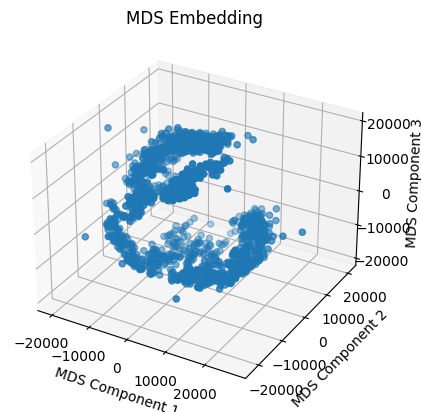

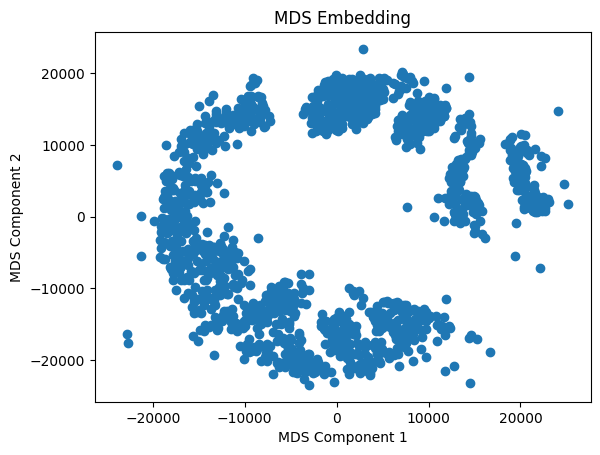

In [ ]:
plot_3d(embeddings)
plot_2d(embeddings_2d)

## Применим разложение Таккера ко всем снимкам перед MDS

In [ ]:
tucker_decomposed = [tucker_decompose(fmris[i] , n_components= 10) for i in tqdm(range(fmris.shape[0]))]

100%|██████████| 1452/1452 [03:25<00:00,  7.07it/s]


In [ ]:
pairwise_distances_tucker = distances(tucker_decomposed)

100%|██████████| 1452/1452 [06:59<00:00,  3.46it/s]


In [ ]:
embeddings_tucker10 , mds_tucker10 = get_MDS_embeddings(pairwise_distances_tucker , n_components = 3)
embeddings_tucker10_2d, mds_tucker10_2d = get_MDS_embeddings(pairwise_distances_tucker , n_components = 2)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


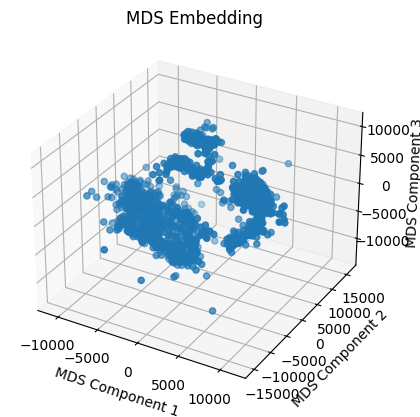

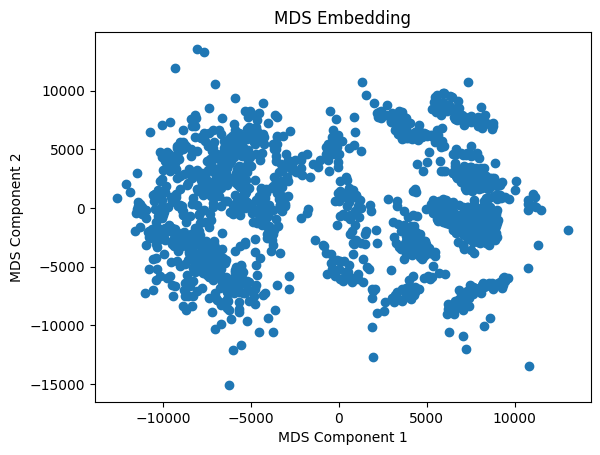

In [ ]:
plot_3d(embeddings_tucker10)
plot_2d(embeddings_tucker10_2d)

## Попробуем меньшее количество компонент в разложении Таккера

In [ ]:
tucker_decomposed_5 = [tucker_decompose(fmris[i] , n_components= 5) for i in tqdm(range(fmris.shape[0]))]

100%|██████████| 1452/1452 [02:24<00:00, 10.07it/s]


In [ ]:
pairwise_distances_tucker_5 = distances(tucker_decomposed_5)

100%|██████████| 1452/1452 [07:37<00:00,  3.17it/s]


In [ ]:
embeddings_tucker5 , mds_tucker5 = get_MDS_embeddings(pairwise_distances_tucker_5 , n_components = 3)
embeddings_tucker5_2d, mds_tucker5_2d = get_MDS_embeddings(pairwise_distances_tucker_5 , n_components = 2)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


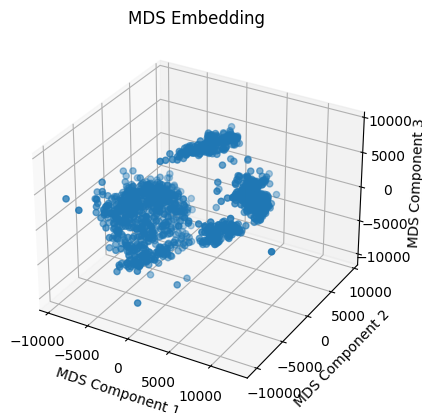

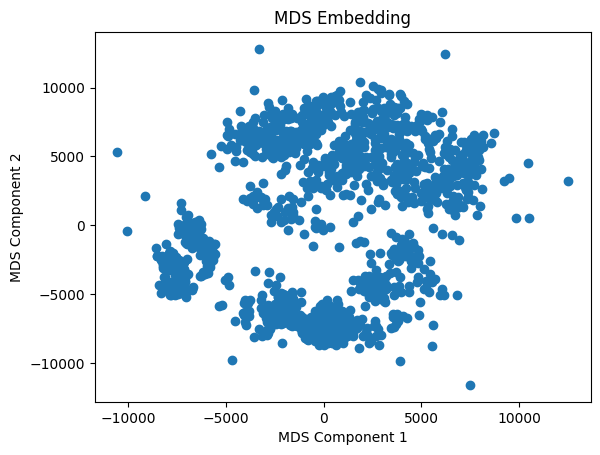

In [ ]:
plot_3d(embeddings_tucker5)
plot_2d(embeddings_tucker5_2d)

## Попробуем 2 компоненты в разложении Таккера

In [ ]:
tucker_decomposed_2 = [tucker_decompose(fmris[i] , n_components= 2) for i in tqdm(range(fmris.shape[0]))]

100%|██████████| 1452/1452 [02:20<00:00, 10.35it/s]


In [ ]:
pairwise_distances_tucker_2 = distances(tucker_decomposed_2)

100%|██████████| 1452/1452 [06:48<00:00,  3.56it/s]


In [ ]:
embeddings_tucker2 , mds_tucker2 = get_MDS_embeddings(pairwise_distances_tucker_2 , n_components = 3)
embeddings_tucker2_2d, mds_tucker2_2d = get_MDS_embeddings(pairwise_distances_tucker_2 , n_components = 2)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


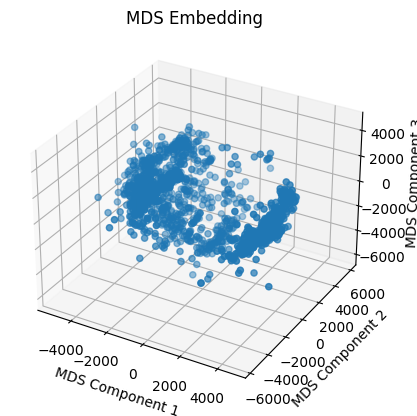

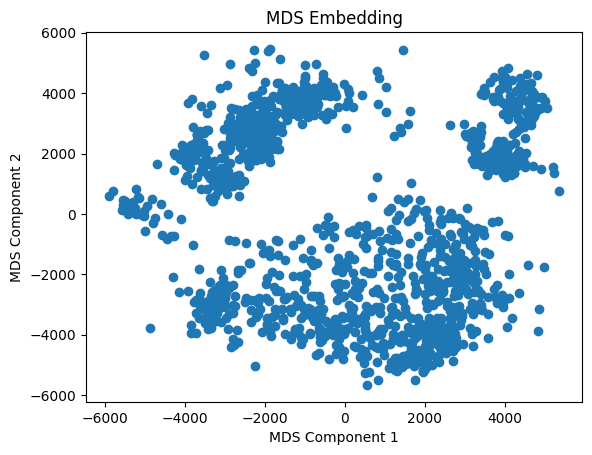

In [ ]:
plot_3d(embeddings_tucker2)
plot_2d(embeddings_tucker2_2d)

## Попробуем также другие разложения: PLS

In [ ]:
pls_decomposed = [PLS_decompose(fmris[i] , n_components= 5) for i in tqdm(range(fmris.shape[0]))]

100%|██████████| 1452/1452 [28:02<00:00,  1.16s/it]


In [ ]:
pls_distances = distances(pls_decomposed)

100%|██████████| 1452/1452 [06:55<00:00,  3.49it/s]


In [ ]:
embeddings_pls5 , mds_pls5 = get_MDS_embeddings(pls_distances , n_components = 3)
embeddings_pls5_2d, mds_pls5_2d = get_MDS_embeddings(pls_distances , n_components = 2)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


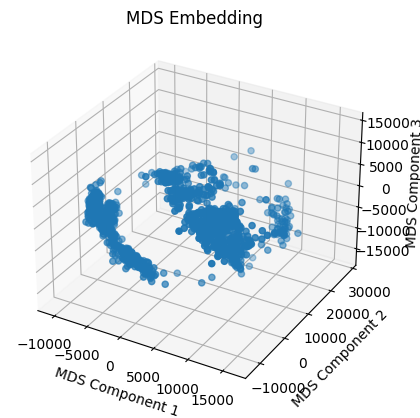

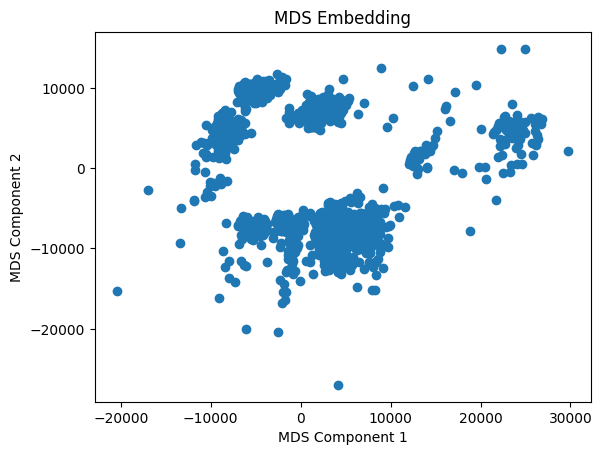

In [ ]:
plot_3d(embeddings_pls5)
plot_2d(embeddings_pls5_2d)

## Попробуем другие MDS

In [ ]:
embeddings_tucker5_nonmetric , mds_tucker5_nonmetric = get_MDS_embeddings(pairwise_distances_tucker_5 , n_components = 3, metric=False)
embeddings_tucker5_nonmetric_2d, mds_tucker5_nonmetric_2d = get_MDS_embeddings(pairwise_distances_tucker_5 , n_components = 2, metric=False)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


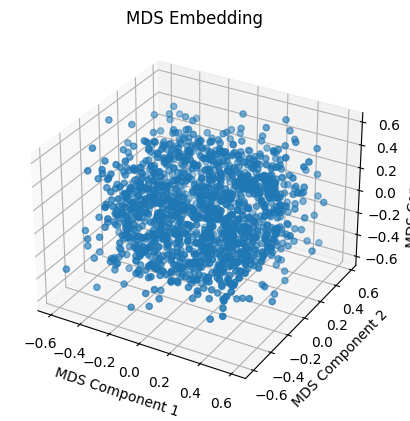

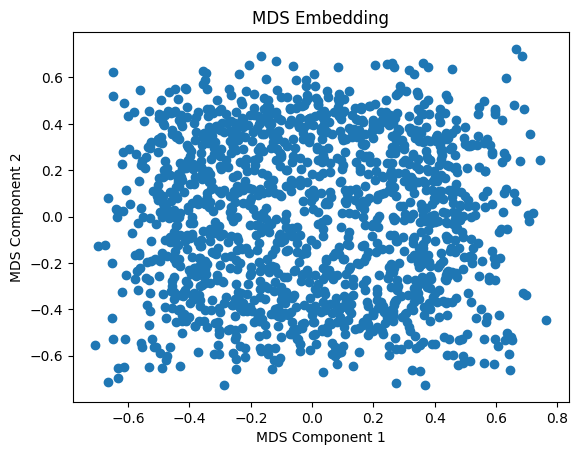

In [ ]:
plot_3d(embeddings_tucker5_nonmetric)
plot_2d(embeddings_tucker5_nonmetric_2d)